In [18]:
import os
import numpy as np
from xml.etree import ElementTree
#from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import argparse
from PIL import Image

In [5]:
def extract_boxes(filename):
    tree = ElementTree.parse(filename)
    root = tree.getroot()
    faceBox = list()
    maskBox = list()
    for obj in root.findall('.//object'):
        box = obj.find('.//bndbox')
        name = str(obj.find('name').text)
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        if(name == 'face_mask'):
            maskBox.append([xmin, ymin, xmax, ymax])
        else:
            faceBox.append([xmin, ymin, xmax, ymax])
    return maskBox,faceBox
    

In [17]:
maskBox,faceBox = extract_boxes('covid-19__face_mask_detection-dataset/COVID-19/example/a2.xml')
print(maskBox[0])

[141, 249, 427, 639]


(0,)


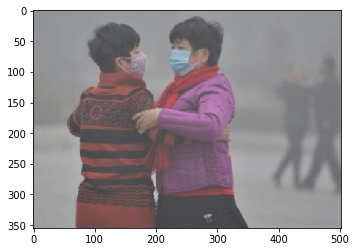

In [18]:
img = plt.imread('covid-19__face_mask_detection-dataset/COVID-19/training/images/test_00000629.jpg')
detector = MTCNN()
faces = detector.detect_faces(img)
print(np.shape(faces))
for face in faces:
    print(face)
plt.imshow(img)
#plt.gca().add_patch(Rectangle((maskBox[0][0],maskBox[0][1]),maskBox[0][2]-maskBox[0][0],maskBox[0][3]-maskBox[0][1],linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

In [19]:
def convert_dataset():
    images_dir = 'covid-19__face_mask_detection-dataset/COVID-19/training/images/'
    annotations_dir = 'covid-19__face_mask_detection-dataset/COVID-19/training/annotations/'
    imagewithmaskdir = 'covid-19__face_mask_detection-dataset/COVID-19/faceOnly/withmask/'
    imagewithoutmaskdir = 'covid-19__face_mask_detection-dataset/COVID-19/faceOnly/withoutmask/'
    allImagesPath = []
    count=100
    for filename in os.listdir(images_dir):
        print(filename)
        image_id = filename[:-4]
        if(filename[-4:]!='.jpg'):
            print("WHY")
        
        img_path = images_dir+filename
        ann_path = annotations_dir + image_id + '.xml'
        img = Image.open(images_dir+filename)
        maskBox,faceBox = extract_boxes(ann_path)
        cnt=0
        for box in maskBox:
            im1 = img.crop(box)
            im1 = im1.convert('RGB')
            im1.save(imagewithmaskdir+image_id+str(cnt)+'.jpg')
            cnt+=1
        cnt=0
        for box in faceBox:
            im1 = img.crop(box)
            im1 = im1.convert('RGB')
            im1.save(imagewithoutmaskdir+image_id+str(cnt)+'.jpg')
            cnt+=1
        
        #allImagesPath.append([image_id,img,maskBox,faceBox])
    
        

In [44]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [6]:
imagePaths = list(paths.list_images('covid-19__face_mask_detection-dataset/COVID-19/faceOnly/'))

In [7]:
cnt=0
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(64, 64))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

In [9]:
npdata = np.array(data, dtype="float32")
nplabels = np.array(labels)

In [10]:
del data

In [11]:
del labels

In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(nplabels)
labels = to_categorical(labels)
del nplabels

In [16]:
(trainX,testX, trainY, testY) = train_test_split(npdata,labels,test_size=0.2, stratify=labels,random_state=56)

In [56]:
aug = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [49]:
base_model = MobileNetV2(weights='imagenet',include_top=False,input_shape=((64,64,3)))

/home/insanenerd/myvenv/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [50]:
headModel = base_model.output
# headModel = AveragePooling2D(pool_size=(, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [51]:
model = Model(inputs = base_model.input,outputs = headModel)
for layer in base_model.layers:
    layer.trainable = False

In [52]:
adam = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [57]:
Hist = model.fit(aug.flow(trainX,trainY,batch_size = BS),
                 validation_data = (testX,testY),
                 steps_per_epoch = (len(trainX))//BS,
                 validation_steps = len(testX)//BS,
                 epochs = EPOCHS
                )

  ...
    to  
  ['...']
Train for 233 steps, validate on 1871 samples
Epoch 1/10
233/233 [==============================] - 17s 73ms/step - loss: 0.3399 - accuracy: 0.8581 - val_loss: 0.2513 - val_accuracy: 0.9062
Epoch 2/10
233/233 [==============================] - 18s 78ms/step - loss: 0.3232 - accuracy: 0.8694 - val_loss: 0.2487 - val_accuracy: 0.9089
Epoch 3/10
233/233 [==============================] - 18s 78ms/step - loss: 0.3199 - accuracy: 0.8662 - val_loss: 0.2400 - val_accuracy: 0.9170
Epoch 4/10
233/233 [==============================] - 18s 76ms/step - loss: 0.3193 - accuracy: 0.8721 - val_loss: 0.2343 - val_accuracy: 0.9219
Epoch 5/10
233/233 [==============================] - 18s 77ms/step - loss: 0.3130 - accuracy: 0.8706 - val_loss: 0.2311 - val_accuracy: 0.9235
Epoch 6/10
233/233 [==============================] - 19s 80ms/step - loss: 0.3009 - accuracy: 0.8769 - val_loss: 0.2341 - val_accuracy: 0.9154
Epoch 7/10
233/233 [==============================] - 18s 79ms/st

In [58]:
model.save('curr_best_model.h5')

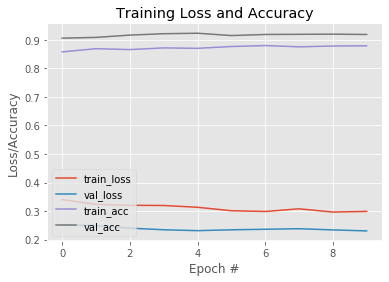

In [61]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), Hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), Hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
